In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime as dt
import jdatetime as jd
from loguru import logger

from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from warnings import filterwarnings
filterwarnings('ignore')


In [4]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 72
plt.style.use('ggplot')
pd.options.display.float_format = '{:.0f}'.format
np.random.seed(0)
np.set_printoptions(precision=2, linewidth=100)
sns.set_context('notebook')
jd.set_locale('en')

In [5]:
revenue = pd.read_csv('data/Dataset.csv', index_col=0)

## EDA

In [80]:
def summary_statistic(df) -> pd.DataFrame:

        """
        Summary statistic of the dataset
        input: dataframe
        output: it will return a dataframe with summary statistic
        """

        feature_describe = df.describe().T.reset_index().rename(
                               columns={'index':'feature'}).drop(columns='count')

        feature_info = pd.concat([df.dtypes,
                                  df.nunique(),
                                  df.isna().sum(),
                                  df.count()], axis=1,
                    keys=['dtype', 'num_unique', 'num_Nan', 'count']).reset_index().rename(columns={'index':'feature'})

        summary_statistic_result = feature_info.merge(feature_describe, how='left', on='feature')

        return summary_statistic_result

In [7]:
summary_statistic(revenue)

,feature,dtype,num_unique,num_Nan,count,mean,std,min,25%,50%,75%,max
0,CustomerID,int64,179680,0,261960,7169337,4957141,465132,3267469,6663396,11227062,46549548
1,OrderID,int64,261960,0,261960,45264897,6121027,32930756,40061748,44792436,50045929,58853188
2,Date,int64,396,0,261960,20193661,4238,20190321,20190821,20191109,20200115,20200419
3,Revenue,int64,3314,0,261960,6110,5647,106,2451,5100,7960,175200


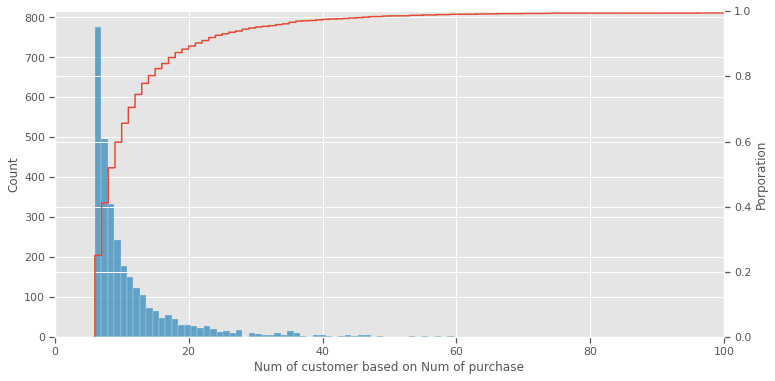

In [84]:
fig, ax1 = plt.subplots()
# ax1.set_title('Average Percipitation Percentage by Month')
ax1.set_xlabel('Num of customer based on Num of purchase')
ax1.set_ylabel('Count')
sns.histplot(revenue.CustomerID.value_counts(sort=True)[revenue.CustomerID.value_counts(sort=True) > 5], ax=ax1)
ax2 = ax1.twinx()
ax2.set_ylabel('Porporation')
sns.ecdfplot(revenue.CustomerID.value_counts(sort=True)[revenue.CustomerID.value_counts(sort=True) > 5], ax=ax2)
ax1.set_xlim(0,100)
ax2.set_xlim(0,100)
plt.show()

In [8]:
for index, row in revenue.iterrows():
    assert len(str(row['Date'])) == 8


### Date feature is surely in need for parsing
both to Jalali datetime and Gregory datetime

In [9]:
def convert_gregorian_persian(df, date_col, format_date):
    '''
    convert gregorian date to Jalali date
    input: dataframe, date column name, date format
    output: dataframe with Jalali date, Jalali Months, Jalali weekdays
    '''

    df['JdDate'] = [jd.date.fromgregorian(date=dt.datetime.strptime(str(i), str(format_date))) for i in df[date_col]]
    df['GDate'] = [dt.datetime.strptime(str(i), str(format_date)) for i in df[date_col]]
    df['GDate'] = [dt.datetime.date(i) for i in df['GDate']]
    df['GDate'] = df['GDate'].astype('datetime64')
    df['JdMonth'] = [jd.datetime.jmonth_short(i) for i in df['JdDate']]
    df['JdWeekday'] = [jd.datetime.jweekday_short(i) for i in df['JdDate']]
    
    return df

In [10]:
revenue = convert_gregorian_persian(revenue,'Date','%Y%m%d')

In [11]:
logger.info(
    f'\n last Gregory Date = {revenue.GDate.max()}, \n last Jalali date = {str(revenue.JdDate.max())}')

2022-04-10 18:14:13.576 | INFO     | __main__:<cell line: 1>:1 - 
 last Gregory Date = 2020-04-19 00:00:00, 
 last Jalali date = 1399-01-31


let's see if we can see the disturbution of Revenue

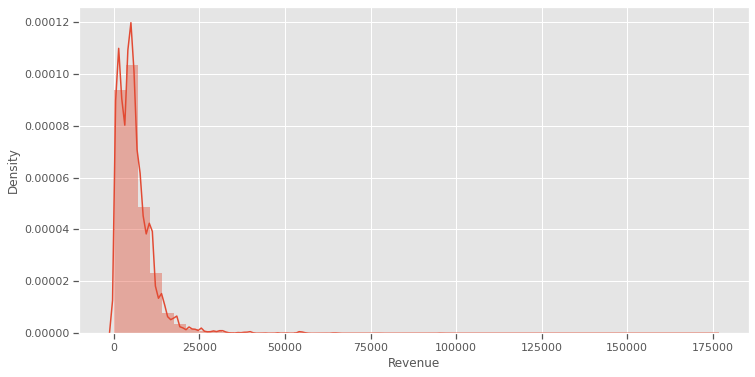

In [85]:
sns.distplot(revenue.Revenue)
plt.show()

most of our variable almosst follow the pareto dist, huh! intresting.


## task 1
1. Average Order Value, Average Frequency, total revenue in each month of 1398. (Based on Persian calendar)

In [12]:
avg_order_val = np.mean(revenue.groupby('OrderID')['Revenue'].mean()) #Average Order Value
avg_freq = np.mean(revenue.groupby('CustomerID')['OrderID'].count()) #Average Frequency

logger.info(f'\n Average Order Value = {avg_order_val: .2f} \n Average Frequency = {avg_freq: .2f}')

2022-04-10 18:14:46.370 | INFO     | __main__:<cell line: 4>:4 - 
 Average Order Value =  6109.57 
 Average Frequency =  1.46


In [125]:
revehnue1398 = revenue[revenue['JdDate']< jd.date(1399, 1, 1)]
logger.info('\n AVG Revenue Per Month in 1388')
summary98 = pd.concat([revehnue1398.groupby(pd.Grouper(key="JdMonth"), as_index=False)\
                      .agg({'Revenue': 'mean','OrderID': 'count', 'CustomerID': 'nunique'})\
                      .rename(columns=
                                    {'Revenue': 'Avg_Revenue' ,
                                    'OrderID': 'Num_Order',
                                    'CustomerID': 'Num_Customer'}),
                       revehnue1398.groupby(pd.Grouper(key="JdMonth"), as_index=False)\
                                            .agg({'Revenue': 'sum'})\
                                                .rename(columns=
                                                {'Revenue': 'Total_Revenue'})\
                                                                .drop(columns='JdMonth')],axis=1)


summary98

2022-04-10 20:47:21.899 | INFO     | __main__:<cell line: 2>:2 - 
 AVG Revenue Per Month in 1388


,JdMonth,Avg_Revenue,Num_Order,Num_Customer,Total_Revenue
0,Far,5983,3279,2789,19618499
1,Ord,6811,3503,3064,23860379
2,Kho,6354,14380,12768,91363493
3,Tir,6615,16228,14122,107350424
4,Mor,5111,28663,24708,146502637
5,Sha,5603,18630,16603,104375481
6,Meh,5642,26699,22541,150623504
7,Aba,5507,33233,28594,183010916
8,Aza,5821,30989,27344,180390183
9,Dey,6659,26642,23048,177407408


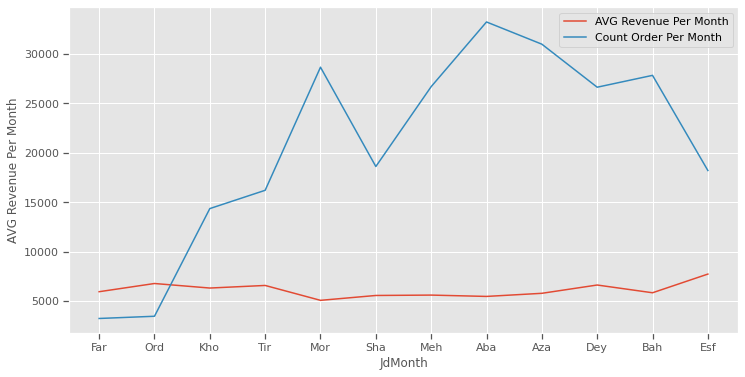

In [14]:
for ind, x in enumerate(summary98.columns[1:-1]):
    # plt.subplot(3,1,ind+1)
    sns.lineplot(data=summary98, x='JdMonth', y=x, label=x)
    # plt.tight_layout()
plt.legend()
plt.show()

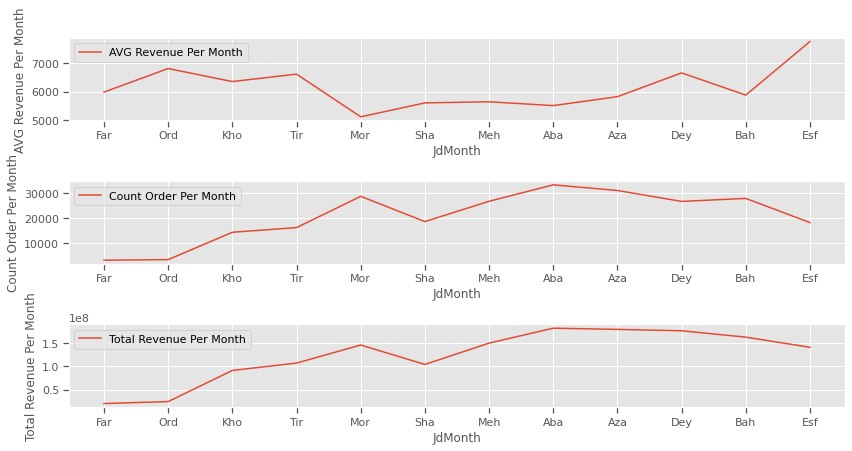

In [15]:
for ind, x in enumerate(summary98.columns[1:]):
    plt.subplot(3,1,ind+1)
    sns.lineplot(data=summary98, x='JdMonth', y=x, label=x)
    plt.tight_layout()
# plt.legend()
plt.show()

In [126]:
# style.applymap(lambda v:'color:red;' if v is True, props='color:red;')\
# .applymap(lambda v:'color:red;' if v is True else None)

pd.concat([summary98.JdMonth, 
           summary98[summary98==summary98.max(numeric_only=True)].drop(columns='JdMonth')],
           axis=1)



,JdMonth,Avg_Revenue,Num_Order,Num_Customer,Total_Revenue
0,Far,NaN,NaN,NaN,NaN
1,Ord,NaN,NaN,NaN,NaN
2,Kho,NaN,NaN,NaN,NaN
3,Tir,NaN,NaN,NaN,NaN
4,Mor,NaN,NaN,NaN,NaN
5,Sha,NaN,NaN,NaN,NaN
6,Meh,NaN,NaN,NaN,NaN
7,Aba,NaN,33233,28594,183010916
8,Aza,NaN,NaN,NaN,NaN
9,Dey,NaN,NaN,NaN,NaN


In [158]:
# rev_agg = revenue.groupby(pd.Grouper(key='GDate', freq='M'))[['Revenue']]
# rev_agg_dict = dict(rev_sum = rev_agg.sum(), rev_mean = rev_agg.mean(), rev_median = rev_agg.median())
# _ = 1
# for k, v in rev_agg_dict.items():
#     # print(v)
#     # break
#     plt.subplot(3,1,_)
#     plt.title(k)
#     sns.lineplot(x=v.index, y=v.Revenue)
#     _ += 1
# plt.tight_layout()
# plt.show()


In [17]:
LASTGDATE = revenue.GDate.max()
LASTJDATE = revenue.JdDate.max()

let's creat Recency, Frequency, Monitize(both on avg and total)

In [116]:
recency = revenue.groupby(['CustomerID'],as_index=False)['JdDate'].max()\
                 .rename(columns={'JdDate': 'LastPurchaseDate'})
recency['Recency'] = recency.LastPurchaseDate.apply(lambda x:(LASTJDATE - x).days)


In [117]:
recency.head()

,CustomerID,LastPurchaseDate,Recency
0,465132,1398-09-09,141
1,465164,1398-12-09,51
2,465198,1399-01-25,6
3,465204,1398-08-12,168
4,465211,1398-11-02,88


<AxesSubplot:xlabel='Recency', ylabel='Count'>

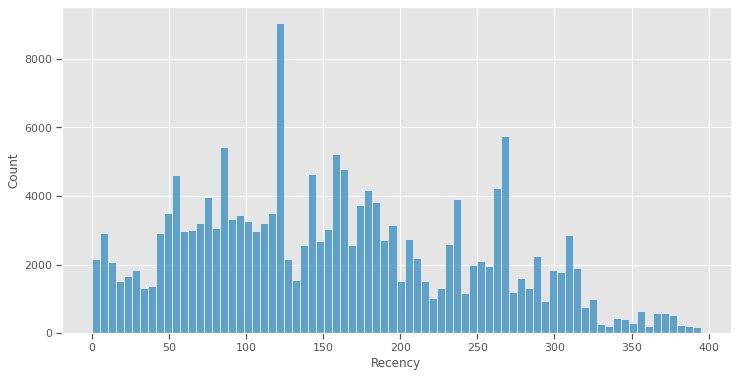

In [161]:
sns.histplot(recency.Recency)

In [19]:
freq_mon = revenue.groupby('CustomerID', as_index=False)\
                  .agg({'OrderID': 'count',
                        'Revenue': 'sum'})\
                  .rename(columns={'OrderID' :'Frequency',
                           'Revenue':'Monetary'})

In [118]:
freq_mon.head()

,CustomerID,Frequency,Monetary,Frequency7
0,465132,1,7302,1
1,465164,1,578,1
2,465198,1,5688,1
3,465204,1,1464,1
4,465211,1,4760,1


In [61]:
sum([1 if i >= 8 else 0 for i in freq_mon.Frequency]) / len(freq_mon) * 100


1.0129118432769368

7 and more than 7 frequency for our customers is barely possible ~= (1 % of freq). hence we might as well join them togheter. this will results a better model.

<AxesSubplot:xlabel='Frequency', ylabel='count'>

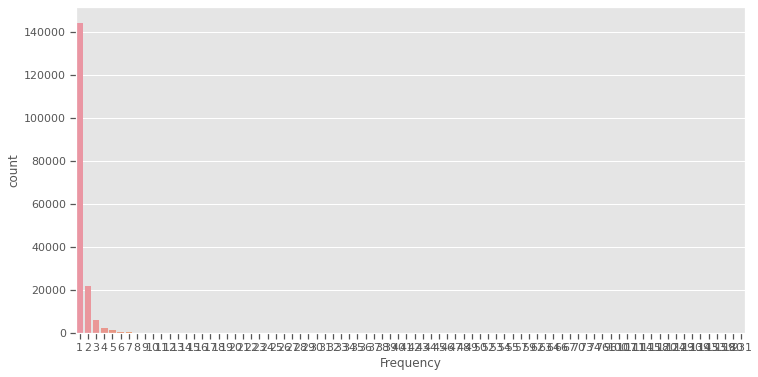

In [163]:
sns.countplot(freq_mon.Frequency)


In [62]:
freq_mon['Frequency7'] = freq_mon.Frequency.apply(lambda x: 7 if x >= 7 else x)

pareto again :)

<AxesSubplot:xlabel='Monetary'>

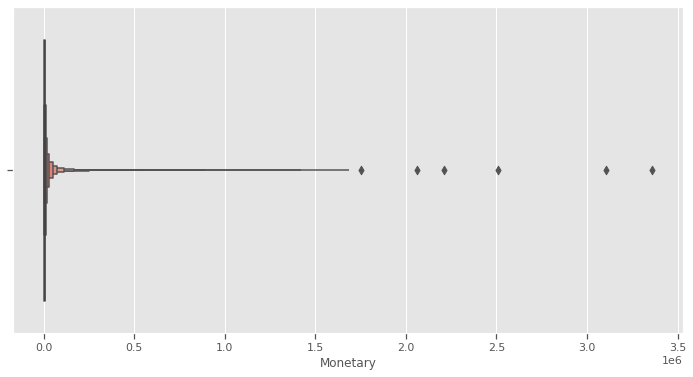

In [164]:
sns.boxenplot(freq_mon.Monetary)

In [63]:
rfm_df = recency.merge(freq_mon,on='CustomerID').drop(columns='LastPurchaseDate')


In [64]:
logger.info(f'Data shape: {rfm_df.shape}')
summary_statistic(rfm_df)

2022-04-10 18:53:04.840 | INFO     | __main__:<cell line: 1>:1 - Data shape: (179680, 5)


,feature,dtype,num_unique,num_Nan,count,mean,std,min,25%,50%,75%,max
0,CustomerID,int64,179680,0,179680,7606196,5001455,465132,3536368,7100330,11658242,46549548
1,Recency,int64,396,0,179680,158,90,0,85,150,232,395
2,Frequency,int64,82,0,179680,1,2,1,1,1,1,231
3,Monetary,int64,16962,0,179680,8907,25864,106,2899,5467,9754,3360683
4,Frequency7,int64,7,0,179680,1,1,1,1,1,1,7


2022-04-10 18:53:51.582 | INFO     | __main__:check_skew:6 - 
 Recency's: Skew: 0.32064945876314715, : SkewtestResult(statistic=54.15561530881222, pvalue=0.0) 

2022-04-10 18:53:53.109 | INFO     | __main__:check_skew:6 - 
 Frequency's: Skew: 29.710390475484978, : SkewtestResult(statistic=605.8684556035356, pvalue=0.0) 

2022-04-10 18:53:54.502 | INFO     | __main__:check_skew:6 - 
 Monetary's: Skew: 50.91426917719234, : SkewtestResult(statistic=681.9671668363789, pvalue=0.0) 

2022-04-10 18:53:55.930 | INFO     | __main__:check_skew:6 - 
 Frequency7's: Skew: 3.7811647640921766, : SkewtestResult(statistic=316.1549177800153, pvalue=0.0) 



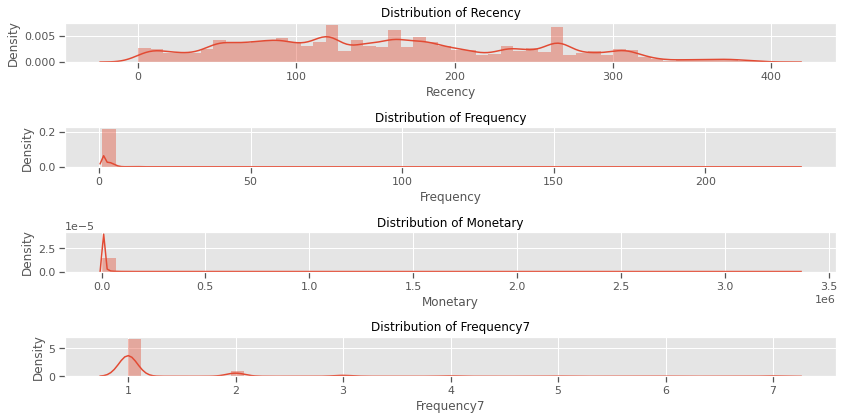

In [66]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column], bins=50)
    return logger.info(f"\n {column}'s: Skew: {skew}, : {skewtest} \n")


for ind, i in enumerate(rfm_df.columns[1:]):
    plt.subplot(4,1, ind+1)
    check_skew(rfm_df, i)
plt.tight_layout()
plt.show()

Obviously, we have to deal with this heavy skewness, and data has extreme outliers. I believe logarithmic scaling for Frequency and Monetary features and winsorizing and standard scaling for all, makes sense.


In [69]:
rfm_log = pd.concat([rfm_df[['CustomerID', 'Recency']], np.log(rfm_df[['Frequency7', 'Monetary']])], axis=1)


In [70]:
summary_statistic(rfm_log)

,feature,dtype,num_unique,num_Nan,count,mean,std,min,25%,50%,75%,max
0,CustomerID,int64,179680,0,179680,7606196,5001455,465132,3536368,7100330,11658242,46549548
1,Recency,int64,396,0,179680,158,90,0,85,150,232,395
2,Frequency7,float64,7,0,179680,0,0,0,0,0,0,2
3,Monetary,float64,16962,0,179680,9,1,5,8,9,9,15


2022-04-10 18:55:45.715 | INFO     | __main__:check_skew:6 - 
 Recency's: Skew: 0.32064945876314715, : SkewtestResult(statistic=54.15561530881222, pvalue=0.0) 

2022-04-10 18:55:47.255 | INFO     | __main__:check_skew:6 - 
 Frequency7's: Skew: 2.321231674303311, : SkewtestResult(statistic=249.76700472478717, pvalue=0.0) 

2022-04-10 18:55:48.886 | INFO     | __main__:check_skew:6 - 
 Monetary's: Skew: -0.3747150407190465, : SkewtestResult(statistic=-62.763502952820964, pvalue=0.0) 



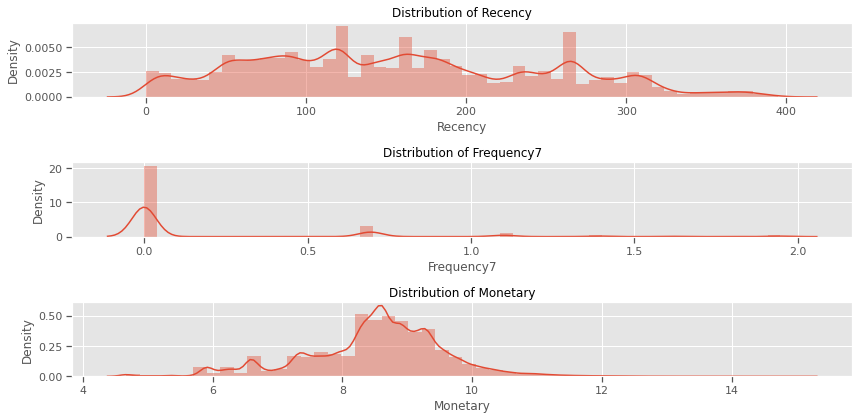

In [72]:
for ind, i in enumerate(rfm_log.columns[1:]):
    plt.subplot(3,1, ind+1)
    check_skew(rfm_log, i)
plt.tight_layout()
plt.show()

In [191]:
# scaler.fit_transform(rfm_df)[:,1:]

array([[-0.19, -0.2 , -0.06],
       [-1.19, -0.2 , -0.32],
       [-1.68, -0.2 , -0.12],
       ...,
       [-1.21, -0.2 ,  1.76],
       [-1.63, -0.2 ,  0.01],
       [ 1.12, -0.2 , -0.17]])

## Clustering

In [73]:
scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfm_log)[:,1:]


2022-04-10 18:56:26.384 | INFO     | __main__:<cell line: 1>:9 - 
 0's: Skew: 0.32064945876314677, : SkewtestResult(statistic=54.15561530881215, pvalue=0.0), variance: 1.0000000000000002 

2022-04-10 18:56:28.290 | INFO     | __main__:<cell line: 1>:9 - 
 1's: Skew: 2.321231674303311, : SkewtestResult(statistic=249.76700472478717, pvalue=0.0), variance: 1.0000000000000002 

2022-04-10 18:56:29.974 | INFO     | __main__:<cell line: 1>:9 - 
 2's: Skew: -0.37471504071904077, : SkewtestResult(statistic=-62.76350295282004, pvalue=0.0), variance: 0.9999999999999999 



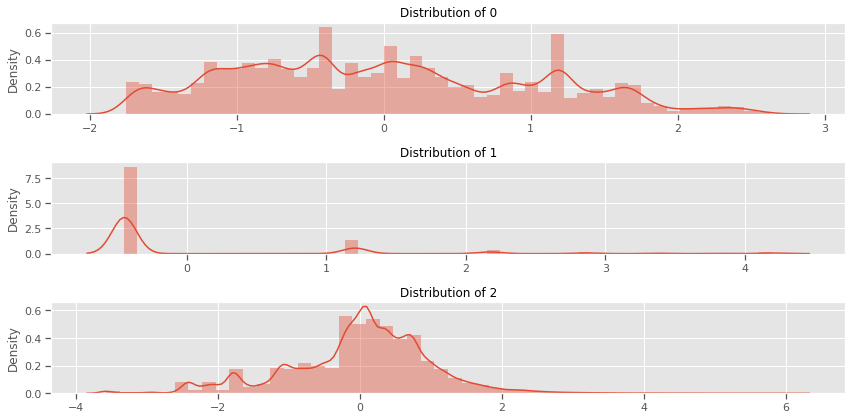

In [74]:
for i in range(3):
    plt.subplot(3,1, i+1)
    # check_skew(rfm_log, i)
    # check_skew(scaler.fit_transform(rfm_df),)
    skew = stats.skew(scaled_rfm[:,i])
    skewtest = stats.skewtest(scaled_rfm[:,i])
    plt.title(f'Distribution of {i}')
    sns.distplot(scaled_rfm[:,i])
    logger.info(f"\n {i}'s: Skew: {skew}, : {skewtest}, variance: {np.var(scaled_rfm[:,i])} \n")
plt.tight_layout()
plt.show()



In [138]:
rfm_scaled = pd.DataFrame(scaled_rfm, columns=rfm_log.columns[1:])

logger.info(f'Data shape: {rfm_scaled.shape}')
summary_statistic(rfm_scaled)

2022-04-10 21:00:30.761 | INFO     | __main__:<cell line: 3>:3 - Data shape: (179680, 3)


,feature,dtype,num_unique,num_Nan,count,mean,std,min,25%,50%,75%,max
0,Recency,float64,396,0,179680,0,1,-2,-1,-0,1,3
1,Frequency7,float64,7,0,179680,-0,1,-0,-0,-0,-0,4
2,Monetary,float64,16962,0,179680,-0,1,-4,-0,0,1,6


In [140]:

# mapping1 = {} 
# mapping2 = {} 
# K = range(1,10) 
  
# def get_distortions(X, y): 
#     distortions = [] 
#     inertias = [] 
#     for k in K: 
#         kmeanModel = KMeans(n_clusters=k).fit(X) 
#         kmeanModel.fit(X) 
#         distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
#                                  'euclidean'), axis=1)) / X.shape[0]) 
#         inertias.append(kmeanModel.inertia_) 
#     return distortions, inertias


# for k in K: 
#     #Building and fitting the model 
#     kmeanModel = KMeans(n_clusters=k).fit(rfm_scaled) 
#     kmeanModel.fit(rfm_log)     
      
#     distortions.append(sum(np.min(cdist(rfm_log, kmeanModel.cluster_centers_, 
#                       'euclidean'),axis=1)) / rfm_log.shape[0]) 
#     inertias.append(kmeanModel.inertia_) 
  
#     mapping1[k] = sum(np.min(cdist(rfm_log, kmeanModel.cluster_centers_, 
#                  'euclidean'),axis=1)) / rfm_log.shape[0] 
#     mapping2[k] = kmeanModel.inertia_ 

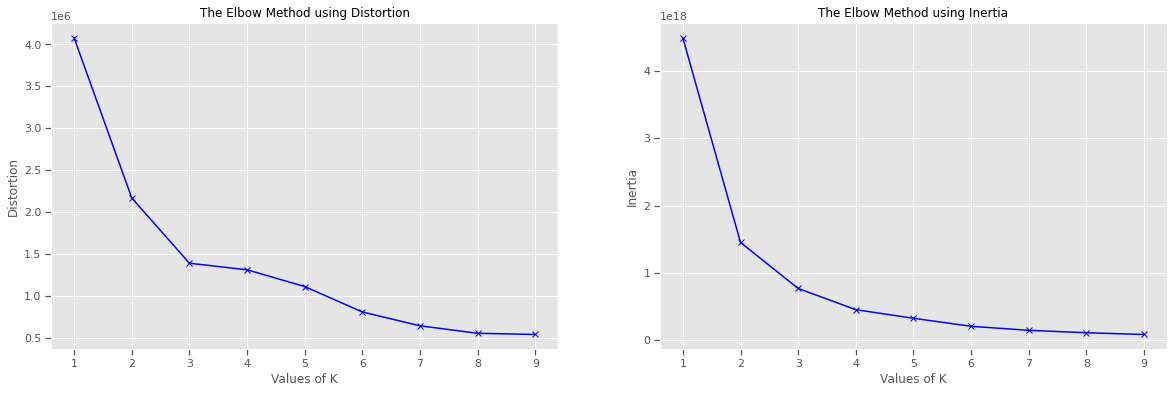

In [78]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 

plt.subplot(1,2,2)
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia')
plt.show() 

In [79]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

NameError: name 'RFM_Table_scaled' is not defined

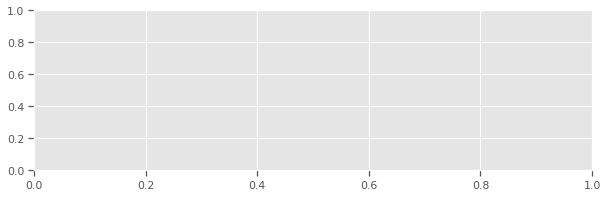

In [132]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, RFM_Table)

plt.tight_layout()

## task 4
Calculate CLV for customers who have been joined in Farvardin. (Assume that each
customer's join date is the same as the date of their first order) (Bonus Question)


CLV = ARPU (Average Revenue per User)/ChurnRate

In [144]:
# revenue.groupby(['Cluster']).agg({'Revenue':'sum'}).sort_values(by='Revenue', ascending=False)

,CustomerID,OrderID,Date,Revenue,JdDate,GDate,JdMonth,JdWeekday
261955,14814009,58778867,20200419,8760,1399-01-31,2020-04-19,Far,Sun
261956,17043123,58761937,20200419,5240,1399-01-31,2020-04-19,Far,Sun
261957,2853558,58757250,20200419,8760,1399-01-31,2020-04-19,Far,Sun
261958,3114170,58818638,20200419,11920,1399-01-31,2020-04-19,Far,Sun
261959,19622158,58850782,20200419,11920,1399-01-31,2020-04-19,Far,Sun


In [149]:
# customer's join date is the same as the date of their first order
customer_join_date = revenue.groupby(['CustomerID'])[['JdDate']].min()

In [161]:
customer_join_date[(customer_join_date.JdDate < jd.date(1398, 2, 1))\
                    | (customer_join_date.JdDate > jd.date(1398, 12, 28))].sort_values(by='JdDate').reset_index()

,CustomerID,JdDate
0,11229102,1398-01-01
1,11253293,1398-01-01
2,11253082,1398-01-01
3,11252738,1398-01-01
4,11253779,1398-01-01
...,...,...
11766,9348762,1399-01-31
11767,3745246,1399-01-31
11768,1246519,1399-01-31
11769,7881620,1399-01-31


In [162]:
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,Frequency7
0,465132,141,1,7302,1
1,465164,51,1,578,1
2,465198,6,1,5688,1
3,465204,168,1,1464,1
4,465211,88,1,4760,1


In [ ]:
revenue[revenue['JdDate']< jd.date(1399, 1, 1)]